In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# Sort table in descending order to find last day
last_day = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
# Convert result object to string
last_day = last_day.date   
# Convert string to datetime object
last_day_obj = dt.datetime.strptime(last_day, '%Y-%m-%d')

# Calculate one year ago
year_ago = last_day_obj - dt.timedelta(days=365)
# Convert date object to string
year_ago = year_ago.strftime("%Y-%m-%d")

print(f'The last day of recorded data was {last_day}.\nOne year prior to the last day was {year_ago}.')

The last day of recorded data was 2017-08-23.
One year prior to the last day was 2016-08-23.


In [12]:
# Perform a query to retrieve the data and precipitation scores
one_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date)

date=[]
precipitation=[]
for row in one_year:
    date.append(row.date)
    precipitation.append(row.prcp)

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(precipitation, date, columns=['Precipitation']).dropna()
prcp_df.head(10)

,Precipitation
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08
2016-08-25,0.00
2016-08-25,0.00


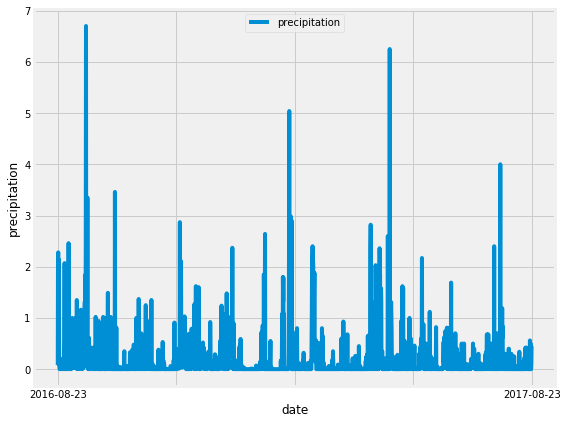

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
dates = prcp_df.index.tolist()
prcp = prcp_df['Precipitation'].tolist()

fig, ax = plt.subplots(figsize = (8,6))

x_axis = np.arange(len(dates))
qrtr = len(dates)/4
xtick_locations = [0, qrtr, qrtr*2, qrtr*3, qrtr*4]
xtick_labels = [year_ago,'','','',last_day]
plt.xticks(xtick_locations, xtick_labels)

plt.xlabel('date')
plt.ylabel('precipitation')

prcp_handle, = plt.plot(x_axis, prcp, label="precipitation")
plt.legend(handles=[prcp_handle], loc='upper center')

plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measurement.station).\
    distinct(Measurement.station).count()
print(f'The number of stations is {num_stations}.')

The number of stations is 9.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())
active_stations.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# `func.min`, `func.max`, `func.avg`, and `func.count`
most_active = active_stations[0][0]

most_active_desc = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

most_active_desc = list(np.ravel(most_active_desc))
print(f'Station: {most_active}\n\
Min Temp: {most_active_desc[0]}\n\
Max Temp: {most_active_desc[1]}\n\
Avg Temp: {most_active_desc[2]}\n')


Station: USC00519281
Min Temp: 54.0
Max Temp: 85.0
Avg Temp: 71.66378066378067



In [19]:
# Choose (filter) the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram (`bins=12`)
most_active_sdata = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date > year_ago).all()

a_date=[]
tobs=[]
for row in most_active_sdata:
    a_date.append(row.date)
    tobs.append(row.tobs)

active_df = pd.DataFrame(tobs, a_date, columns=['tobs']).dropna()

# print(min(active_df['tobs']))
# print(max(active_df['tobs']))

tobs_bins = [59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83]
tobs_groups = ["60", "62", "64", "66", "68", "70", "72", "74", "76", "78", "80", "82"]

active_df["tobs_bin"] = pd.cut(active_df["tobs"], tobs_bins, labels=tobs_groups)
active_df.head()

tobs_count_df = active_df.groupby(['tobs_bin']).count()
tobs_count_df


,tobs
tobs_bin,
60,3
62,10
64,10
66,20
68,31
70,40
72,40
74,72
76,63


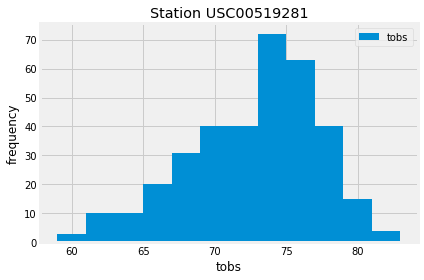

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
tobs = tobs_count_df.index.tolist()
tobs_count = tobs_count_df['tobs'].tolist()

fig, ax = plt.subplots(figsize = (6,4))

x_axis = np.arange(12)
xtick_locations = [value*2.5 for value in x_axis]
xtick_labels = np.arange(60,85,5)
plt.xticks(xtick_locations, xtick_labels)
plt.xlabel('tobs', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title(f'Station {most_active}')

plt.bar(tobs, tobs_count, label="tobs", width=1.0)
plt.legend()

plt.tight_layout()
plt.show()

### Temperature Analysis II

* The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-07-03'
trip_end = '2017-07-13'

trip_data = calc_temps(trip_start, trip_end)

print(f"Trip Dates: {trip_start} to {trip_end}\n\
Min Temp: {trip_data[0][0]}\n\
Avg Temp: {trip_data[0][1]}\n\
Max Temp: {trip_data[0][2]}\n")

Trip Dates: 2017-07-03 to 2017-07-13
Min Temp: 69.0
Avg Temp: 78.02816901408451
Max Temp: 87.0



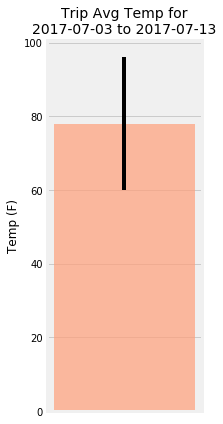

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_data = list(np.ravel(trip_data))

tmin = trip_data[0]
tavg = trip_data[1]
tmax = trip_data[2]
yerr = tmax-tmin

fig, ax = plt.subplots(figsize = (3,6))

xtick_locations = [-1,1]
plt.xticks(xtick_locations)

plt.ylabel('Temp (F)', fontsize=12)
plt.title(f'Trip Avg Temp for\n{trip_start} to {trip_end}', fontsize=14)

plt.bar(0, tavg, yerr=yerr, width=0.5, color='lightsalmon', alpha=0.7)

plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
all_stations = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    join(Station, Measurement.station==Station.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
all_stations

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.4900000000000002),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.1600000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.64),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.38),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.15000000000000002),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.13),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

### Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

* You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [25]:
# Query for all temperature observations in a specified month (from any year)
def monthly_tobs(month):
    return session.query(Measurement.tobs).\
        filter(func.strftime("%m", Measurement.date) == month).all()

# Convert results to lists
jun_tobs = monthly_tobs('06')
jun_tobs = list(np.ravel(jun_tobs))

dec_tobs = monthly_tobs('12')
dec_tobs = list(np.ravel(dec_tobs))

# Print mean temperatures
print(f"The mean temperature for June was {np.mean(jun_tobs)}.")
print(f"The mean temperature for December was {np.mean(dec_tobs)}.")

The mean temperature for June was 74.94411764705882.
The mean temperature for December was 71.04152933421226.


In [26]:
from scipy import stats

# Independent T-Test for two unrelated, independent months
(t_stat, p) = stats.ttest_ind(jun_tobs, dec_tobs, equal_var=False)

# Print p-value results
if p < 0.05:
    print(f"Since the p-value ({p}) was < 0.05, the difference in mean temperatures between June and December are statistically significant.")
else:
    print("The difference in mean temperatures between June and December are likely due to chance.")

Since the p-value (4.193529835915755e-187) was < 0.05, the difference in mean temperatures between June and December are statistically significant.


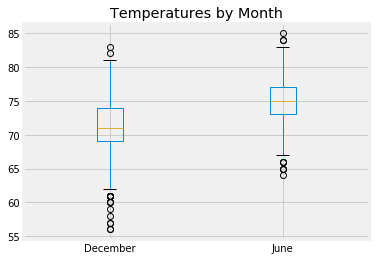

In [27]:
# Boxplot temperatures
jun_cols = pd.DataFrame(jun_tobs, columns=['tobs'])
jun_cols['month'] = 'June'
dec_cols = pd.DataFrame(dec_tobs, columns=['tobs'])
dec_cols['month'] = 'December'
months_compare = pd.concat([jun_cols,dec_cols])

months_compare.boxplot(column='tobs', by='month')
plt.title('Temperatures by Month')
plt.suptitle("")
plt.xlabel("")
plt.show()


### <del>Daily Rainfall Average</del> Temperature Analysis II continued (?)

* <del>Calculate the rainfall per weather station using the previous year's matching dates.</del> (see above)

* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

* You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

* Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

* Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2017-07-03'
trip_end = '2017-07-13'

# Convert strings to date objects
trip_start = dt.datetime.strptime(trip_start, "%Y-%m-%d")
trip_end = dt.datetime.strptime(trip_end, "%Y-%m-%d")

# Use the start and end date to create a list of dates
trip_dates = []
step = dt.timedelta(days=1)

# Strip off the year and save a list of %m-%d strings
while trip_start <= trip_end:
    date = dt.datetime.strftime(trip_start,"%m-%d")
    trip_dates.append(date)
    trip_start += step

trip_dates

['07-03',
 '07-04',
 '07-05',
 '07-06',
 '07-07',
 '07-08',
 '07-09',
 '07-10',
 '07-11',
 '07-12',
 '07-13']

In [34]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for date in trip_dates:
    results = daily_normals(date)
    normals.append(results[0])
    
normals

[(68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0)]

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals,columns=['tmin','tavg','tmax'])
normals_df['date'] = trip_dates
normals_df = normals_df.set_index('date')
normals_df

,tmin,tavg,tmax
date,,,
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0
07-10,68.0,75.620690,82.0
07-11,70.0,75.789474,81.0


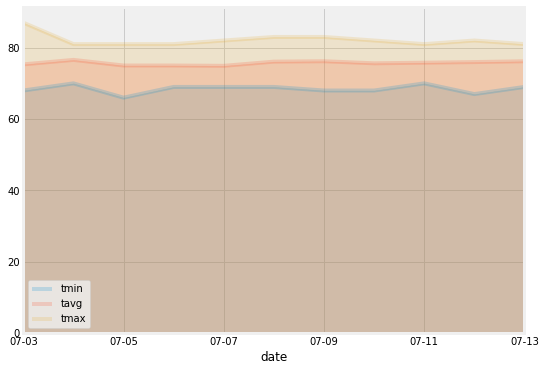

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, alpha=0.2, figsize=(8,6))
plt.legend(('tmin', 'tavg', 'tmax'), loc='lower left')
plt.show()